
# Example analysis/prediction: Churn prediction for telecompany
**Goal description:**
<br>
I was provided with a dataset from a telecommunications company. The data contains information about almost six thousand users, their demographic characteristics, the services they use, the duration of using the operator's services, the method of payment, and the amount of payment.
<br>

My task was to analyze the data and predict the churn of users (identify people who will and will not renew their contract). The work should includes the following:
1. Description of the data,
2. Research of dependencies and hypotheses formulation,
3. Building models for predicting churn *(with justification for the choice of a particular model)* based on tested hypotheses and identified relationships,
4. Comparison of the quality of the obtained models with the general conclusions of the work.
<br>
_________

[Codebook](#Codebook) <br>
[1. Description of the data](#1.)<br>
[2. Research of dependencies and hypotheses formulation](#2.)<br>
[3. Building models for predicting churn](#3.)<br>
[4. Comparison of the quality of the obtained models with the general conclusions of the work](#4.) <br>


In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency, ttest_ind

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
from sklearn.preprocessing import scale, StandardScaler, QuantileTransformer
from sklearn.exceptions import FitFailedWarning
from sklearn.utils._testing import ignore_warnings
scaler = StandardScaler()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


## Codebook
<br>

[data_source](https://drive.google.com/open?id=1dPCG76ST6NohYKtVMGv6HpFL-jD5p1eJ) 
<br><br>

`telecom_users.csv` has following features:<br><br>

&nbsp;&nbsp;&nbsp;&nbsp; `customerID` <br>
&nbsp;&nbsp;&nbsp;&nbsp; `gender` (male/female)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `SeniorCitizen` - (1, 0)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Partner` – (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Dependents` –  (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `tenure` – month of being customer <br>
&nbsp;&nbsp;&nbsp;&nbsp; `PhoneService` – (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MultipleLines` – phone lines (Yes, No, No phone service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `InternetService` – (DSL, Fiber optic, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineSecurity` – subcription for internet service  (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineBackup` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `DeviceProtection` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TechSupport` –  (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingTV` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingMovies` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Contract` – (Month-to-month, One year, Two year)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaperlessBilling` – (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaymentMethod` – (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MonthlyCharges`  <br>
&nbsp;&nbsp;&nbsp;&nbsp; `TotalCharges` <br>
&nbsp;&nbsp;&nbsp;&nbsp; `Churn` -(Yes or No)<br>

#1. Description of the data

In [163]:
telecom_users_df = pd.read_csv('telecom_users.csv')
print(telecom_users_df.shape)
telecom_users_df.head(3)

(5986, 22)


,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes


In [164]:
# dataset seems to not have na's
nan_check = telecom_users_df.isna().sum()
nan_check[nan_check>0]

Series([], dtype: int64)

In [165]:
# verifying dtpes of columns
telecom_users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


**Formatting**: <br>
Firstly, I will adopt numerical output instead of strings with consistent no as 0 encoding. 
Dataset has some linear features in the object data type which means that they have to be converted to float: MonthlyCharges, TotalCharges



In [166]:
# easy way to encode categories automatically although labels on InternetService are not consistent with the rest of fetures
future_cat_columns = list(telecom_users_df.nunique()[telecom_users_df.nunique() < 5].index)
for column_name in future_cat_columns:
    print(column_name, ':', 
          dict(enumerate(telecom_users_df[column_name].astype('category').cat.categories)))

gender : {0: 'Female', 1: 'Male'}
SeniorCitizen : {0: 0, 1: 1}
Partner : {0: 'No', 1: 'Yes'}
Dependents : {0: 'No', 1: 'Yes'}
PhoneService : {0: 'No', 1: 'Yes'}
MultipleLines : {0: 'No', 1: 'No phone service', 2: 'Yes'}
InternetService : {0: 'DSL', 1: 'Fiber optic', 2: 'No'}
OnlineSecurity : {0: 'No', 1: 'No internet service', 2: 'Yes'}
OnlineBackup : {0: 'No', 1: 'No internet service', 2: 'Yes'}
DeviceProtection : {0: 'No', 1: 'No internet service', 2: 'Yes'}
TechSupport : {0: 'No', 1: 'No internet service', 2: 'Yes'}
StreamingTV : {0: 'No', 1: 'No internet service', 2: 'Yes'}
StreamingMovies : {0: 'No', 1: 'No internet service', 2: 'Yes'}
Contract : {0: 'Month-to-month', 1: 'One year', 2: 'Two year'}
PaperlessBilling : {0: 'No', 1: 'Yes'}
PaymentMethod : {0: 'Bank transfer (automatic)', 1: 'Credit card (automatic)', 2: 'Electronic check', 3: 'Mailed check'}
Churn : {0: 'No', 1: 'Yes'}


In [167]:
# InternetService will be encoded "by hand " and SeniorCitizen is in good format already
future_cat_columns.remove('InternetService')
future_cat_columns.remove('SeniorCitizen')

for column_name in future_cat_columns:
          telecom_users_df[column_name] = telecom_users_df[column_name]\
          .astype('category').cat.codes
telecom_users_df.InternetService = telecom_users_df.InternetService\
    .map({'No':0, 'DSL': 1 ,'Fiber optic':2})
# TotalCharges shows only str dtypes 
telecom_users_df.TotalCharges.apply(type).value_counts()
# but at this example str -> float formatting fails, because the string is an empty space
telecom_users_df.TotalCharges[356:360]
# replacing empty space strings with nan's and formatting
telecom_users_df.TotalCharges = telecom_users_df.TotalCharges.replace(r'^\s*$', np.nan, regex=True)
telecom_users_df.TotalCharges = telecom_users_df.TotalCharges.astype('float')
# formatting customerID as str
telecom_users_df.customerID = telecom_users_df.customerID.astype('str')
telecom_users_df.TotalCharges = telecom_users_df.TotalCharges.replace(r'^\s*$', np.nan, regex=True)

# now dataset has only 10 missing values which can be simply dropped 
telecom_users_df.isna().sum()
telecom_users_df.dropna(inplace=True)

# Unnamed - unlcear feature with no description, leaving it in place just in case
telecom_users_df['Unnamed: 0'].astype('int')
telecom_users_df.rename(columns = {'Unnamed: 0': 'Unnamed0'}, inplace=True)
# doublechecking dtypes
telecom_users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5976 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed0          5976 non-null   int64  
 1   customerID        5976 non-null   object 
 2   gender            5976 non-null   int8   
 3   SeniorCitizen     5976 non-null   int64  
 4   Partner           5976 non-null   int8   
 5   Dependents        5976 non-null   int8   
 6   tenure            5976 non-null   int64  
 7   PhoneService      5976 non-null   int8   
 8   MultipleLines     5976 non-null   int8   
 9   InternetService   5976 non-null   int64  
 10  OnlineSecurity    5976 non-null   int8   
 11  OnlineBackup      5976 non-null   int8   
 12  DeviceProtection  5976 non-null   int8   
 13  TechSupport       5976 non-null   int8   
 14  StreamingTV       5976 non-null   int8   
 15  StreamingMovies   5976 non-null   int8   
 16  Contract          5976 non-null   int8   


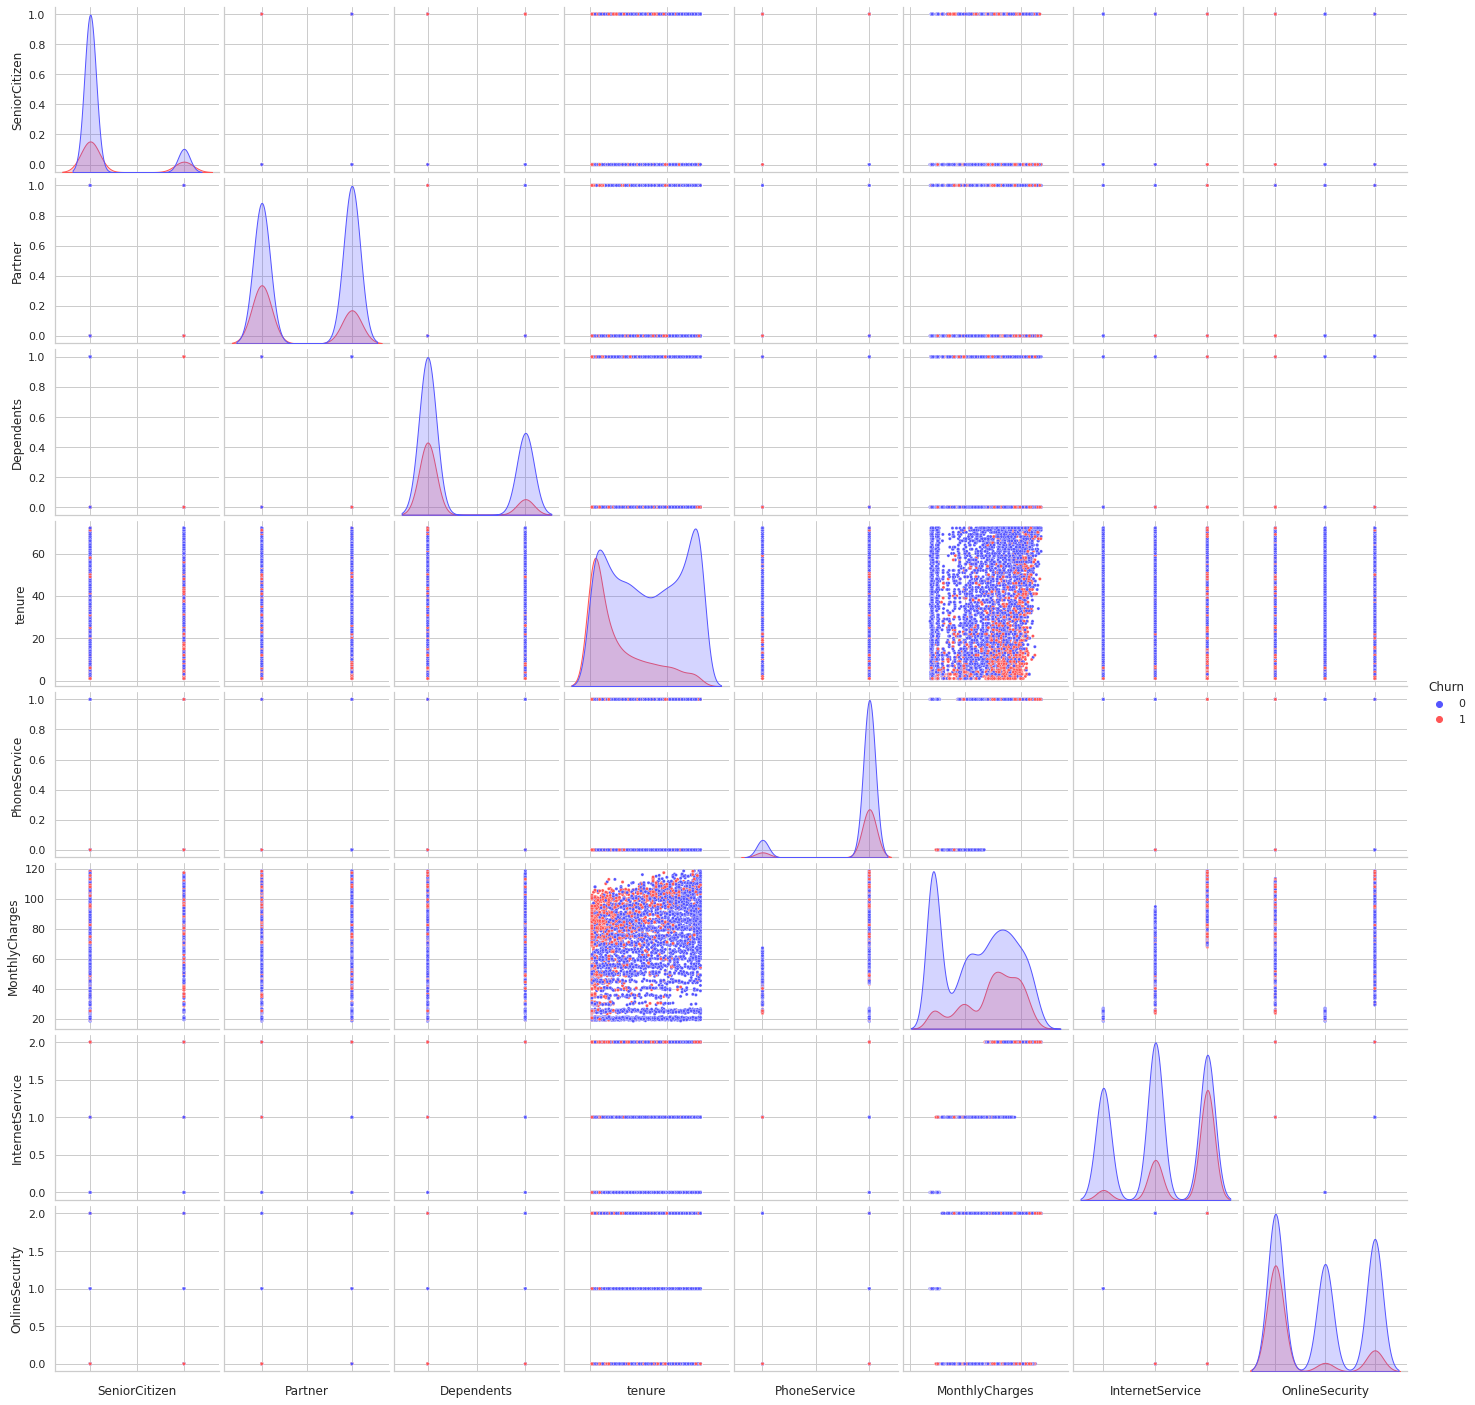

In [168]:
# more data insight can be obtained from the pairplot with selected features 
plot_features = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 
'PhoneService', 'MonthlyCharges', 'InternetService', 'OnlineSecurity', 'Churn']
g = sns.pairplot(telecom_users_df[plot_features], 
                 hue='Churn', palette = 'seismic',  plot_kws=dict(s=10))
g.set(xticklabels=[])

# 2. Data exploration and hypothesis formulation

In [169]:
# target metric is somewhat unbalanced, therefore assigning weights to models and dataset stratification will be helpful
telecom_users_df['Churn'].value_counts()

0    4389
1    1587
Name: Churn, dtype: int64

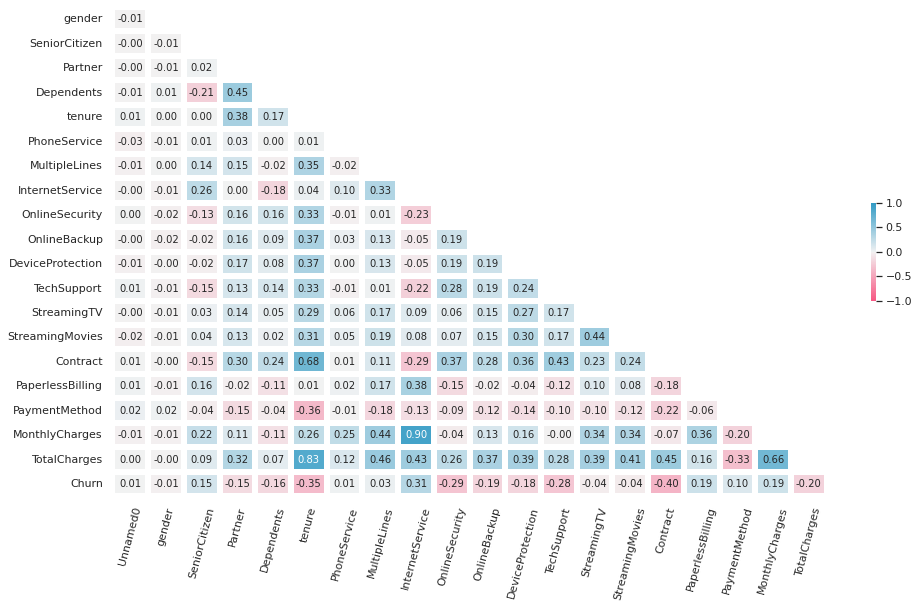

In [170]:
# checking any feature correlations 
fig, ax = plt.subplots(figsize = (16,9))
df_corr = telecom_users_df.corr()

# mask to show only half of the heatmp
mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(
    corr, mask=mask, annot=True, vmin=-1, vmax=1, 
    linewidths=5, cmap=cmap, 
    cbar_kws={"shrink": .2} , fmt='.2f', square=False)

yticks = [i for i in corr.index]
xticks = [i for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks, rotation=75)
plt.show()

In [171]:
# outpuing highest correlations 
c = df_corr.abs()
s = c.unstack()
so = s.sort_values()
so[(so > .5) & (so != 1)]

TotalCharges     MonthlyCharges     0.656534
MonthlyCharges   TotalCharges       0.656534
tenure           Contract           0.677012
Contract         tenure             0.677012
tenure           TotalCharges       0.827439
TotalCharges     tenure             0.827439
InternetService  MonthlyCharges     0.903810
MonthlyCharges   InternetService    0.903810
dtype: float64

**Correlations** <br>
Most features are not strongly correlated, with the exception of: Monthly Charges/Internet Service and Total Charges/tenure. In such a situation, to simplify future models, you can try remove one of feature in pair, while maintaining a logical connection and simplifying the model, therefore increasing the generalisation. <br> User churn - does not correlate strongly with any of the indicators directly although some relationships might be unravelled while grouping by other features.

<br>**Hypotheses** <br>
Since most of the data is categorical, you check churn distribution differences in different groups depending on: gender, retirement status, present partner/children,  subscription to the Internet and/or Internet services, type of contract and payment. You can use $\chi^2$ test in such situation to verify distribution of churn between groups
For identification of differences in monthly and total payments (linear features) of customers who left vs remained - you can use $t-$ student test. 

In [172]:
def hypcheck(base_feature:str, sec_feature:str):
    """chi-squared test, for binary feature """
    sec_feature_churn = telecom_users_df.groupby([base_feature])[sec_feature].value_counts()
    
    # displaying groups as ratios
    ratio = sec_feature_churn.div(
        sec_feature_churn.groupby(sec_feature).sum(), level=1)\
        .apply(lambda x: round(x,4))\
        .unstack(level=0)
    
    # chi-square test of independence of variables in a contingency table
    stat, p, dof, expected = chi2_contingency(sec_feature_churn.unstack(level=0).transpose())
    
    return [p, sec_feature_churn.unstack(level=0), ratio]

**Retirement status:** non retired clients show a tendency to remain with the company while retirement status does not impact significantly a decision for provider change

In [173]:
# distributions are different (low p-value); 
print(hypcheck('Churn', 'SeniorCitizen')[0])
print(hypcheck('Churn', 'SeniorCitizen')[1])
hypcheck('Churn', 'SeniorCitizen')[2]

8.820350350117542e-31
Churn             0     1
SeniorCitizen            
0              3825  1185
1               564   402


Churn,0,1
SeniorCitizen,,
0,0.7635,0.2365
1,0.5839,0.4161


In [174]:
# enhancing previous function to accept list of features
def feature_chek(chi2_cont_pv:list, features:list):
    # chi2_cont_pv list to save p-values
    for feature in features:
        results = hypcheck('Churn', feature)
        if results[0] < 0.025:
            print(feature.upper(),"p-value:", results[0], '\n')
            print(results[2])
        if results[0] > 0.025:
            print('*'*8,  'no significant differences found')
            print(feature.upper(),"p-value:", results[0], '\n')
        chi2_cont_pv.append(results[0])


In [175]:
# analysis of churn distribution by general customer related features
chi2_cont_pv = [] # собираю результаты сюда
features = ['SeniorCitizen','gender', 'Dependents', 'Partner', 'MultipleLines']

feature_chek(chi2_cont_pv=chi2_cont_pv, features=features)
churn_feature_corr = pd.DataFrame(zip(features,chi2_cont_pv), 
                                  columns=['feature', 'chi2_p']).sort_values('chi2_p')
churn_feature_corr['label'] = 'General'
churn_feature_corr.head(10)

SENIORCITIZEN p-value: 8.820350350117542e-31 

Churn               0       1
SeniorCitizen                
0              0.7635  0.2365
1              0.5839  0.4161
******** no significant differences found
GENDER p-value: 0.4866935816649469 

DEPENDENTS p-value: 1.4600096175509e-34 

Churn            0       1
Dependents                
0           0.6887  0.3113
1           0.8422  0.1578
PARTNER p-value: 1.5321519855940942e-29 

Churn         0       1
Partner                
0        0.6718  0.3282
1        0.8011  0.1989
MULTIPLELINES p-value: 0.020161009617758144 

Churn               0       1
MultipleLines                
0              0.7485  0.2515
1              0.7466  0.2534
2              0.7159  0.2841


,feature,chi2_p,label
2,Dependents,1.460010e-34,General
0,SeniorCitizen,8.820350e-31,General
3,Partner,1.532152e-29,General
4,MultipleLines,2.016101e-02,General
1,gender,4.866936e-01,General


Based on the p-value of the $\ chi2 $ test for the distribution of a feature vs churn, you can see: 
- no significant difference of chrun by **gender** 
- relative to client with no **dependants**, clients with dependants remain with the company more often 
- clients with **partner** remain more often than those without
- churn is not dependant on presence of one or more **phone lines**

In [176]:
# analysis of chrun distribution by subscription to internet service
chi2_cont_pv = []
features = ['InternetService', 'OnlineSecurity', 'TechSupport', 
            'OnlineBackup', 'DeviceProtection', 'StreamingTV','StreamingMovies']
feature_chek(chi2_cont_pv=chi2_cont_pv, features=features)

newframe = pd.DataFrame(zip(features,chi2_cont_pv), columns=['feature', 'chi2_p'])
newframe['label'] = 'Internet'
churn_feature_corr = pd.concat([churn_feature_corr,newframe]).sort_values('chi2_p')


INTERNETSERVICE p-value: 1.8038967777298862e-129 

Churn                 0       1
InternetService                
0                0.9230  0.0770
1                0.8077  0.1923
2                0.5847  0.4153
ONLINESECURITY p-value: 2.3735908101882943e-155 

Churn                0       1
OnlineSecurity                
0               0.5835  0.4165
1               0.9230  0.0770
2               0.8561  0.1439
TECHSUPPORT p-value: 2.409809520622001e-147 

Churn             0       1
TechSupport                
0            0.5870  0.4130
1            0.9230  0.0770
2            0.8464  0.1536
ONLINEBACKUP p-value: 1.0802137306833908e-108 

Churn              0       1
OnlineBackup                
0             0.6014  0.3986
1             0.9230  0.0770
2             0.7844  0.2156
DEVICEPROTECTION p-value: 9.245797213355548e-102 

Churn                  0       1
DeviceProtection                
0                 0.6093  0.3907
1                 0.9230  0.0770
2                 0.77

From test above, you can notice that: 
- clients without **Internet connection** are less likely to change provider compared to client with **DSL connection**, while clients with **FiberOptic connection** are the highest of those three groups to not renew the contract 
- subscription to any of **Internet Services** reduces likelyhood of a client churn, especially in case of subscriptions to Online Security and Tech Support

In [177]:
# аналогично проверяю оставшиеся признаки
chi2_cont_pv = []
features = ['Contract', 'PaperlessBilling', 'PaymentMethod']

feature_chek(chi2_cont_pv=chi2_cont_pv, features=features)

newframe = pd.DataFrame(zip(features,chi2_cont_pv), columns=['feature', 'chi2_p'])
newframe['label'] = 'Plan'
churn_feature_corr = pd.concat([churn_feature_corr,newframe]).sort_values('chi2_p')

CONTRACT p-value: 1.4339377471429975e-217 

Churn          0       1
Contract                
0         0.5723  0.4277
1         0.8839  0.1161
2         0.9714  0.0286
PAPERLESSBILLING p-value: 5.508736417353613e-48 

Churn                  0       1
PaperlessBilling                
0                 0.8344  0.1656
1                 0.6650  0.3350
PAYMENTMETHOD p-value: 1.2170201734870093e-114 

Churn               0       1
PaymentMethod                
0              0.8285  0.1715
1              0.8479  0.1521
2              0.5503  0.4497
3              0.8069  0.1931


- clients with shorter **contracts** are more likely to leave  relative to ones with longer contracts
- clients with automatic **payments** or payment by check less often change the provider compared to clients using electronic transfers

In [178]:
# final gathered p-values
churn_feature_corr.reset_index(drop=True, inplace = True)
churn_feature_corr

,feature,chi2_p,label
0,Contract,1.433938e-217,Plan
1,OnlineSecurity,2.373591e-155,Internet
2,TechSupport,2.409810e-147,Internet
3,InternetService,1.803897e-129,Internet
4,PaymentMethod,1.217020e-114,Plan
5,OnlineBackup,1.080214e-108,Internet
6,DeviceProtection,9.245797e-102,Internet
7,StreamingMovies,1.783122e-67,Internet
8,StreamingTV,3.890601e-67,Internet
9,PaperlessBilling,5.508736e-48,Plan


In [179]:
# you can see clear differences in median payments among people who left vs stayed 
# Total Charges are higher for customers who remained because of higher tenure 
# therefore only Monthly Charges are likely to bring some meaningful information here
print(telecom_users_df.groupby(['Churn']).TotalCharges.median())
print(telecom_users_df.groupby(['Churn']).MonthlyCharges.median())
print(telecom_users_df.groupby(['Churn']).tenure.median())

Churn
0    1689.45
1     706.60
Name: TotalCharges, dtype: float64
Churn
0    64.8
1    79.5
Name: MonthlyCharges, dtype: float64
Churn
0    38
1    10
Name: tenure, dtype: int64


In [180]:
# t student test shows apperent diferences
MonthlyCharges_staay = telecom_users_df[telecom_users_df.Churn == 0]['MonthlyCharges']
MonthlyCharges_chrun = telecom_users_df[telecom_users_df.Churn == 1]['MonthlyCharges']
ttest_ind(MonthlyCharges_staay, MonthlyCharges_chrun)


Ttest_indResult(statistic=-14.641506990041831, pvalue=1.0164607928359582e-47)

In [181]:
# differences in MonthlyCharges are even more apparent for clients grouped by contract type
# high Charges on long/medium type contract might be correlated with Chrun
print(telecom_users_df.groupby(['Churn', 'Contract']).MonthlyCharges.median())

Churn  Contract
0      0           65.000
       1           64.850
       2           64.350
1      0           78.450
       1           96.175
       2           98.300
Name: MonthlyCharges, dtype: float64


Comparison of median values with t-student test showed that
**Monthly Charges** were significantly higher among lost clients. TotalCharges are higher among clients that remained with the provider but that is the result of feature calculation which is likely: Monthly Charges x tenure. <br>
Interestingly, the split in Monthly Charges by Churn if you group data further by **Contract** type (short/long term) comparnig but as not apparent in other data groups. 


Text(0.5, 0.98, 'Distribution of median monthly charges by feature')

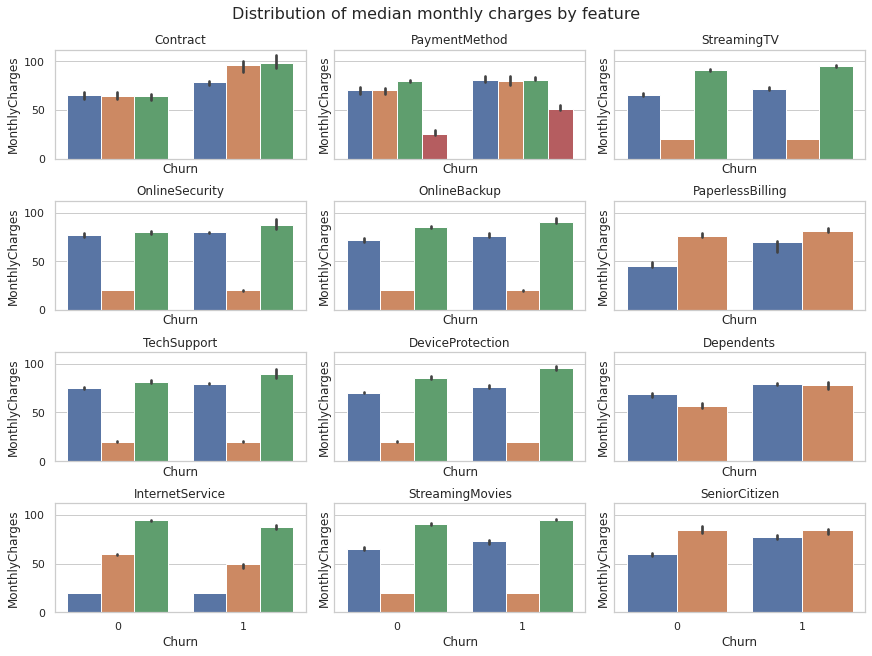

In [182]:
# selecting some column names to plot
cat_features  = list(churn_feature_corr.feature.values)[:-3]

# subplot
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12,9), 
                        sharex=True, sharey=True, constrained_layout=True)
# iterate through selected column names and plot with sns
for i, feature in enumerate(cat_features):
    if 3 < i <=7:
        ax=axs[i-4][1]
    elif i >7:
        ax = axs[i-8][2]
    else:
        ax=axs[i][0]
    g = sns.barplot(data = telecom_users_df, y='MonthlyCharges', x = 'Churn', 
                    hue = feature ,estimator = np.median, ax=ax)
    g.set_title(feature)
    g.legend_.remove()
fig.suptitle('Distribution of median monthly charges by feature', fontsize= 16)


# 3. Building models for predicting churn

In [183]:
# a good balance between roc_auc scoring will be a good balanced metric in this case

# transfroming linear features (CategoricalNB does not accept negative features)
quantile_transformer = QuantileTransformer(random_state=42)
telecom_users_df['MonthlyCharges'] = quantile_transformer.fit_transform(telecom_users_df[['MonthlyCharges']])
telecom_users_df['tenure'] = quantile_transformer.fit_transform(telecom_users_df[['tenure']])

# selecting features for models and leaving target as the last 
sel_features = list(churn_feature_corr.feature.values)
sel_features = sel_features + ['MonthlyCharges', 'tenure', 'Churn']

# removing InternetService because of the high correlation with MonthlyCharges
sel_features.remove('InternetService')

# removing those features after investigation of feature importance on first models fits
sel_features.remove('gender')
sel_features.remove('MultipleLines')
sel_features.remove('Partner')

# train test split
data = telecom_users_df[sel_features]
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(columns='Churn'), data['Churn'], test_size=.2,
    random_state=42, shuffle=True, stratify = data['Churn'])

print(f'X_train shape: {x_train.shape}, y_train shape: {y_train.shape},\n'
      f'X_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

# setting cross validation
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=7, random_state=42)

# handy function for evaluation of model fits
def evaluate_model(model, x_test,y_test):
    def output(model): 
        score = cross_val_score(model, x_test, y_test, cv=10, scoring='roc_auc')
        mean_score = round(score.mean(),4)
        mean_std = round(score.std(), 4)
        print('Best roc_auc: ', mean_score, f'({mean_std})') 
        return (mean_score, mean_std, score)        
    
    if isinstance(model, sklearn.model_selection._search.RandomizedSearchCV):
        print(model.best_params_)
        return output(model)
    else:
        return output(model)
        
        

# sample weights to account for small target imbalance
balance = [{0:1,1:10}, {0:1,1:20}, {0:1,1:30}]
weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=[0,1], y=data['Churn'])
balance.append(dict(zip([0,1], weights)))
balance.append(None)

X_train shape: (4780, 13), y_train shape: (4780,),
X_test shape: (1196, 13), y_test shape: (1196,)


In [184]:
# creating dictionaries with parameters for RandomizedSearchCV
knn_params = {'n_neighbors': range(1,20),
             'weights': ['uniform', 'distance']}
tree_params = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range (1, 12),
    "min_samples_split": range (1,12),
    "min_samples_leaf": range (1,5),
    "class_weight":balance}

lr_params = dict()
lr_params['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
lr_params['penalty'] = [None, 'l1', 'l2', 'elasticnet']
lr_params['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
lr_params['max_iter'] = [100, 1000, 5000, 10000]
lr_params['class_weight'] = balance

nb_params = {'var_smoothing': np.logspace(0,-9, num=10)}
cnb_params = {'alpha': np.arange(0,2,0.2),
             'fit_prior': [False, True]}

svc_param = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],
             'kernel': ['rbf', 'poly', 'sigmoid'],
             'class_weight':balance}

xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'class_weight': balance}

forrest_params = {'n_estimators': [100, 250, 500],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [None, 5, 10],
               'min_samples_split': [2, 5, 9],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False],
               'class_weight': balance}

In [185]:
# setting GridSearch for models
knn = KNeighborsClassifier()
knn_grid = RandomizedSearchCV(knn, knn_params, cv=cv, verbose=False, 
                              scoring='roc_auc', random_state=42)

tree = DecisionTreeClassifier()
tree_grid = RandomizedSearchCV(tree, tree_params, cv=cv, verbose=False,
                               scoring = 'roc_auc', random_state=42)

lr = LogisticRegression()
lr_grid = RandomizedSearchCV(lr, lr_params, cv=cv, verbose = False,
                             scoring='roc_auc', random_state=42, n_jobs=-1)

nb = GaussianNB()
nb_grid = RandomizedSearchCV(nb, nb_params, cv=cv,verbose=False, 
                             scoring='roc_auc', random_state=42)

cnb = CategoricalNB()
cnb_grid = RandomizedSearchCV(cnb, cnb_params, cv=cv, verbose=False, 
                              scoring ='roc_auc', random_state=42)

svc_grid = RandomizedSearchCV(SVC(), svc_param,verbose=False, cv=cv, 
                              scoring = 'roc_auc', n_jobs=-1, random_state=42)

xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, 
                    objective='binary:logistic',
                    eval_metric = 'logloss', verbose=0)
xgb_grid = RandomizedSearchCV(xgb, xgb_params,  cv=cv, verbose=False,
                              scoring='roc_auc', n_jobs=-1, random_state=42)

forrest = RandomForestClassifier()
forrest_grid = RandomizedSearchCV(forrest, forrest_params, cv=cv,random_state=42,
                                 scoring = 'roc_auc', verbose=False, n_jobs=-1)

grids_n_model = [knn_grid, tree_grid, lr_grid, nb_grid, cnb_grid, xgb_grid]
grids_n_model_names = ['knn', 'tree', 'lr', 'nb', 'cnb', 'xgb'] 
 


In [186]:
def train_grids(list_with_your_grids:list, _x_train, _y_train, _x_test, _y_test):
    """ Fit and evaluate models from the list"""
    grids_n_model_results = {}

    with ignore_warnings(category=(FitFailedWarning, UserWarning)):
        #silencing warnings of incompatible parameters 
        for i, grid_model in enumerate(list_with_your_grids):
            if isinstance(grid_model.estimator, sklearn.svm._classes.SVC) == True:
                print('svc fitting')
                grid_model.fit(scaler.fit_transform(_x_train), _y_train)
            else:  
                print('fitting', i)  
                grid_model.fit(_x_train, _y_train)
            model_result = evaluate_model(grid_model, _x_test, _y_test)
            grids_n_model_results[f'{grids_n_model_names[i]}'] = model_result[2]

            print(f"{grids_n_model_names[i].upper()}", model_result[0])
        return grids_n_model_results
            


In [187]:
def plot_feature_importance():
    features_label = np.array(sel_features[:-1])
    from sklearn.inspection import permutation_importance
    fig, axs = plt.subplots(figsize = (16,9), ncols=2, nrows=3)
    for i, fit in enumerate(grids_n_model):
        if i ==6:
            break    
        if fit == svc_grid:
            result = permutation_importance(fit, scaler.fit_transform(x_train), y_train, 
                                        n_repeats=5, random_state=42, n_jobs=-1)
        else:
            result = permutation_importance(fit, x_train, y_train, n_repeats=5, 
                                        random_state=42, n_jobs=-1)
        sorted_idx = result.importances_mean.argsort()    
        if i <=2:
            ax = axs[i][0]
        elif i >2:
            ax = axs[i-3][1]    
        ax.boxplot(
            result.importances[sorted_idx].T, vert=False, labels=features_label[sorted_idx]
        )
        ax.set_title(f"Permutation Importance of each feature in {grids_n_model_names[i]}", fontsize = 12)
        ax.set_ylabel("")
        fig.tight_layout()
    plt.show()

## Model fitting

In [188]:
grids_n_model_results = train_grids(grids_n_model, 
                                    x_train, y_train, x_test, y_test)

fitting 0
{'weights': 'uniform', 'n_neighbors': 19}
Best roc_auc:  0.7836 (0.0593)
KNN 0.7836
fitting 1
{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'gini', 'class_weight': {0: 0.6807928913192071, 1: 1.882797731568998}}
Best roc_auc:  0.7901 (0.0462)
TREE 0.7901
fitting 2
{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 100, 'class_weight': None, 'C': 10}
Best roc_auc:  0.8301 (0.0497)
LR 0.8301
fitting 3
{'var_smoothing': 1e-08}
Best roc_auc:  0.8125 (0.0476)
NB 0.8125
fitting 4
{'fit_prior': False, 'alpha': 0.0}
Best roc_auc:  0.7904 (0.0565)
CNB 0.7904
fitting 5
{'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 5, 'colsample_bytree': 0.6, 'class_weight': {0: 1, 1: 10}}
Best roc_auc:  0.8261 (0.0518)
XGB 0.8261


In [190]:
# setting up stacking separately and passing to base models best params 
level0 = []
lr_best_params = {'C': 10, 'class_weight': None, 'max_iter': 100,
                  'penalty': 'l2','solver': 'newton-cg'}
level0.append(('knn_trained', KNeighborsClassifier(**grids_n_model[0].best_params_)))
level0.append(('tree', DecisionTreeClassifier(**grids_n_model[1].best_params_)))
level0.append(('lr', LogisticRegression(**lr_best_params)))
level0.append(('nb', GaussianNB()))
level0.append(('svc', SVC()))
level0.append(('xgb', XGBClassifier(**grids_n_model[5].best_params_)))
level0.append(('forrest', RandomForestClassifier()))

meta_stack_clf = StackingClassifier(estimators=level0, 
    final_estimator = RandomizedSearchCV(
        xgb, xgb_params, cv=cv, verbose = False,scoring='roc_auc', 
        random_state=42, n_jobs=-1),cv=5)

meta_fit = meta_stack_clf.fit(x_train,y_train)
stacking_score = cross_val_score(
    meta_fit, x_test, y_test, cv=10, scoring='roc_auc')

# adding stacking results to all results
grids_n_model_results['stacking'] = stacking_score
grids_n_model.append(meta_fit)
grids_n_model_names.append('stacking')

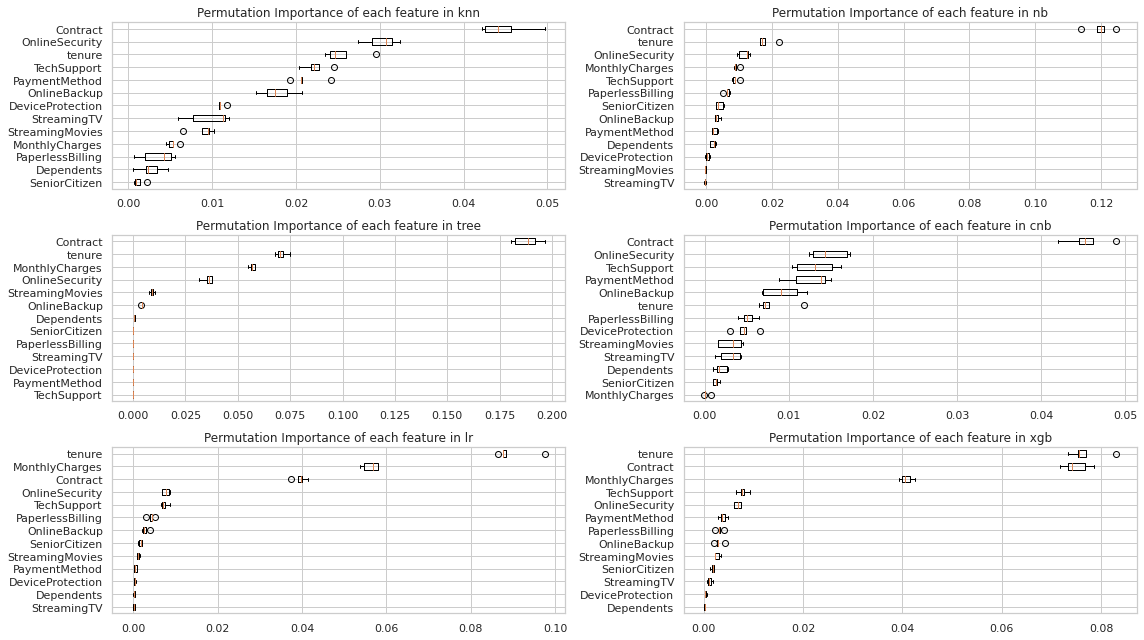

In [191]:
plot_feature_importance()

# 4. Comparison of the quality of the obtained models

From the plot bellow you can see that top 3 models judged by roc_auc score from cross validation are: XGB classifier, stacking classifier and logistic regression. Further on from roc curve I can find even better balance for between precision and recall and output it: 

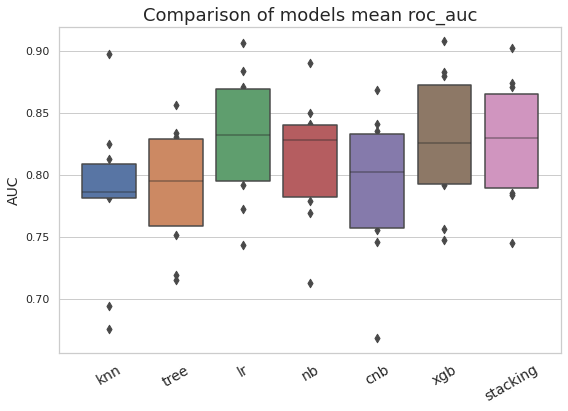

In [192]:
def plot_compare_models(results:dict):
    """ Results: dict where keys are models and values are arrays of recall scores from cv"""
    df_res = pd.DataFrame(results)
    df_res = df_res.melt(var_name='model', value_name='roc_auc')
    fig, ax = plt.subplots(figsize = (9,6))
    sns.boxenplot(data = df_res,  x = 'model', y = 'roc_auc', ax=ax)
    ax.set_title('Comparison of models mean roc_auc', fontsize = 18)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30, fontsize=14)
    ax.set_ylabel('AUC', fontsize=14)

    
    plt.plot()
plot_compare_models(grids_n_model_results)

In [206]:
# displaying mean roc_auc:
final_results = []
for name, grid in zip(grids_n_model_names,grids_n_model):
    final_results.append([name,roc_auc_score(
        y_test, grid.predict_proba(x_test)[:,1])])
final_results.sort(key = lambda x: x[1], reverse=True)
final_results

[['xgb', 0.8417143020873626],
 ['stacking', 0.8390800275067691],
 ['lr', 0.8349002879614905],
 ['tree', 0.8207171100700563],
 ['nb', 0.8180488101889658],
 ['knn', 0.8019190269480381],
 ['cnb', 0.7966200340969327]]

LR Best Threshold=0.225403, G-Mean=0.757


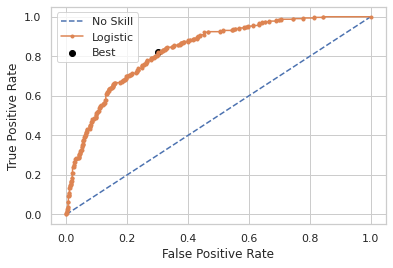

Finall recall 0.8207547169811321
Finall accuracy 0.7307692307692307
XGB Best Threshold=0.251800, G-Mean=0.763


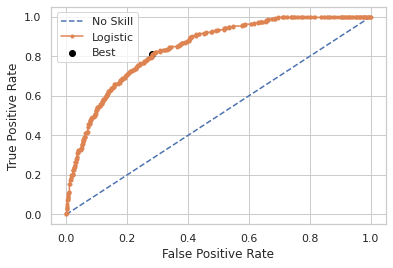

Finall recall 0.8113207547169812
Finall accuracy 0.7424749163879598
STACKING Best Threshold=0.261171, G-Mean=0.760


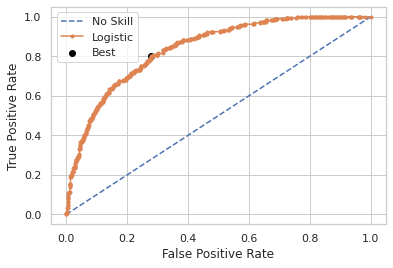

Finall recall 0.8018867924528302
Finall accuracy 0.7424749163879598


In [223]:
# finding even better balance between recall and sensitivity 
# by adjusting classification threshold for models
top_3_models_id = [i for i,x in enumerate(grids_n_model_names) if x in ('lr', 'xgb', 'stacking')]
name_grid_zip = [(grids_n_model_names[i], grids_n_model[i]) for i in top_3_models_id]
for name, grid in name_grid_zip:
    pred = grid.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print(name.upper(), 'Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # lowering the threshold
    change_pred = (grid.predict_proba(x_test)[:,1] >= thresholds[ix]).astype(int)
    print('Finall recall', recall_score(y_test, change_pred))
    print('Finall accuracy',accuracy_score(y_test, change_pred))